# Ejercicio resuelto: Matriz de confusión con *iris.csv*

**Objetivo**: cargar el dataset `iris.csv`, entrenar un modelo sencillo y obtener la matriz de confusión y las métricas:
- Exactitud (Accuracy)
- Precisión (Precision)
- Sensibilidad / TPR (Recall)
- Especificidad / TNR (Specificity)
- Razón de falsos positivos (FPR)

Clasificación binaria: **versicolor** (1) vs. **resto** (0).

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from matplotlib.colors import LinearSegmentedColormap

def load_iris_from_csv_or_sklearn(url: str):
    try:
        df = pd.read_csv(url)
        if 'species' in df.columns:
            return df
    except Exception:
        pass
    # Fallback: sklearn iris
    iris = datasets.load_iris(as_frame=True)
    df = iris.frame.copy()
    rename_map = {
        'sepal length (cm)': 'sepal_length',
        'sepal width (cm)': 'sepal_width',
        'petal length (cm)': 'petal_length',
        'petal width (cm)': 'petal_width',
    }
    df = df.rename(columns=rename_map)
    species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
    df['species'] = df['target'].map(species_map)
    return df[['sepal_length','sepal_width','petal_length','petal_width','species']]

## 1) Cargar datos y preparar el problema (versicolor vs resto)

In [9]:
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv'
df = load_iris_from_csv_or_sklearn(url)
df['is_versicolor'] = (df['species'] == 'versicolor').astype(int)
X = df[['sepal_length','sepal_width','petal_length','petal_width']].values
y = df['is_versicolor'].values
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,is_versicolor
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


## 2) Entrenar un modelo sencillo

In [10]:
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred[:10]

print(clf)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')


## 3) Matriz de confusión

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
TP, FN, FP, TN = cm.ravel()
cm

array([[ 3, 12],
       [ 5, 25]], dtype=int64)

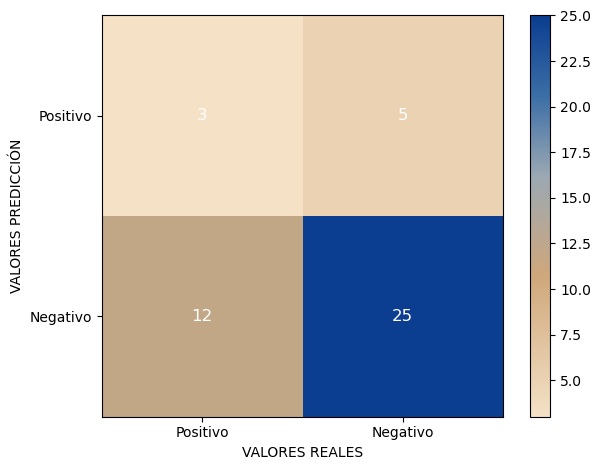

In [12]:
# 1. Colormap personalizado
brown_to_blue = LinearSegmentedColormap.from_list(
    "brown_to_blue",
    [
        (0.00, "#F4E1C6"),  # marrón muy claro (arena)
        (0.35, "#CFA77B"),  # marrón/tan medio
        (0.60, "#9BA8B3"),  # gris-azulado suave
        (0.80, "#3C6EA6"),  # azul medio
        (1.00, "#0B3D91"),  # azul oscuro
    ],
    N=256
)

# 2. Matriz en el orden que quieres (Predicción vs Realidad)
cm_vista = np.array([
    [TP, FP],   # Pred. Positivo  → [TP, FP]
    [FN, TN]    # Pred. Negativo  → [FN, TN]
])

# 3. Plot
fig, ax = plt.subplots()

# Aquí va la MATRIZ, y el colormap como 'cmap'
im = ax.imshow(cm_vista, cmap=brown_to_blue)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Positivo', 'Negativo'])      # VALORES REALES
ax.set_yticklabels(['Positivo', 'Negativo'])      # VALORES PREDICCIÓN

ax.set_xlabel('VALORES REALES')
ax.set_ylabel('VALORES PREDICCIÓN')

# (opcional) barra de color
plt.colorbar(im, ax=ax)

# 4. Escribir los números de la matriz en cada celda
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_vista[i, j],
                ha='center', va='center', color='white', fontsize=12)

plt.tight_layout()
plt.show()


## 4) Cálculo de métricas

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
def safe_div(num, den):
    return float(num)/den if den!=0 else float('nan')

accuracy = safe_div(TP + TN, cm.sum())
precision = safe_div(TP, TP + FP)
recall = safe_div(TP, TP + FN)          # Sensibilidad / TPR
specificity = safe_div(TN, TN + FP)     # Especificidad / TNR
fpr = safe_div(FP, FP + TN)             # 1 - Specificity

print('TP, TN, FP, FN =', TP, TN, FP, FN)
print(f'Accuracy   : {accuracy:.3f}')
print(f'Precision  : {precision:.3f}')
print(f'Recall/TPR : {recall:.3f}')
print(f'Specificity: {specificity:.3f}')
print(f'FPR        : {fpr:.3f}')

# Informe con precision, recall, f1-score, support
print("\nInforme de clasificación:\n")
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

TP, TN, FP, FN = 3 25 5 12
Accuracy   : 0.622
Precision  : 0.375
Recall/TPR : 0.200
Specificity: 0.833
FPR        : 0.167

Informe de clasificación:

              precision    recall  f1-score   support

           0       0.68      0.83      0.75        30
           1       0.38      0.20      0.26        15

    accuracy                           0.62        45
   macro avg       0.53      0.52      0.50        45
weighted avg       0.58      0.62      0.58        45



## 5) Resultados (con `random_state=42`)
- **TP**: 3
- **TN**: 25
- **FP**: 5
- **FN**: 12
- **Accuracy**: 0.622
- **Precision**: 0.375
- **Recall/TPR (Sensibilidad)**: 0.200
- **Specificity/TNR (Especificidad)**: 0.833
- **FPR (1 - Specificity)**: 0.167

> Nota: si cambias el `random_state` o el modelo, los valores podrán variar.

| Métrica                           | Qué mide                                                   | Interpretación                             |
| --------------------------------- | ---------------------------------------------------------- | ------------------------------------------ |
| **Precision (clase 1)** = 0.375   | De los que predijo como 1, solo el 37,5 % eran realmente 1 | Muchos falsos positivos                    |
| **Recall/TPR (clase 1)** = 0.20   | Solo detecta el 20 % de los casos reales de clase 1        | Falla 8 de cada 10 positivos reales        |
| **Specificity (clase 0)** = 0.833 | Detecta bien la clase 0 en el 83 % de los casos            | Muy buena sensibilidad a la clase negativa |
| **FPR (clase 0)** = 0.167         | 16,7 % de errores prediciendo 1 cuando era 0               | Bastante bajo                              |
| **F1-score (clase 1)** = 0.26     | Media entre precisión y recall                             | Bastante débil para clase 1                |


| Tipo de promedio | Significado                              | Valor | Conclusión                                                        |
| ---------------- | ---------------------------------------- | ----- | ----------------------------------------------------------------- |
| **macro avg**    | Media simple entre clases (sin ponderar) | 0.50  | El modelo rinde bajo en general si tratamos las clases por igual  |
| **weighted avg** | Media ponderada según el nº de casos     | 0.58  | Similar a la accuracy (62 %) porque la clase 0 tiene más ejemplos |
